In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np 
import warnings
import optuna
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from data_downloader import DataDownloader, ClimateDataCleaner, EconomicDataCleaner
from vr_model import ClimateVR
from sdice_model import SimplifiedDICE
from portfolio import PortfolioOptimizer

In [2]:
# Instancia para limpiar y procesar los datos climáticos
climate_cleaner = ClimateDataCleaner('Data/Temperature.csv', 'Data/Drought_Severity.csv', 'Data/CO2_Emissions.xlsx')
climate_data = climate_cleaner.clean_and_prepare_data()

# Instancia para limpiar y procesar los datos climáticos
economic_cleaner = EconomicDataCleaner('Data/GDP.csv', 'Data/TB3MS.csv', 'Data/CPI.csv')
economic_data = economic_cleaner.clean_and_prepare_data()

# Descarga los datos financieros
downloader = DataDownloader()
assets = ['AAPL', 'IBM', 'TSLA', 'GOOG', 'NVDA', 'NEE', 'FSLR', 'VWDRY', 'BEP'] 
benchmark = '^GSPC'  
start_date = '2014-11-01'
end_date = '2024-05-31'
rf = .065

asset_prices, benchmark_prices = downloader.download_data(start_date=start_date, 
                                                          end_date=end_date, 
                                                          assets=assets, 
                                                          benchmark=benchmark)

all_data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]
all_data.drop('Date', axis=1, inplace=True)

[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
# Definir la función objetivo para Optuna
def objective(trial):
    # Elige el número de retardos entre 1 y 10
    maxlags = trial.suggest_int('maxlags', 1, 10)

    # Ajustar el modelo VR con el número de retardos sugerido
    vr_model = ClimateVR(all_data)
    vr_results = vr_model.fit(maxlags=maxlags)

    # Realizar predicciones con el número de retardos sugerido
    predicted = vr_model.predict(vr_results, lags=maxlags, end=100)

    # Definir los valores reales (esto es solo un ejemplo, debes usar tus valores reales)
    actual = all_data[maxlags:100]  # Ajusta según la longitud de tus datos

    # Asegurarse de que predicted y actual tengan la misma longitud
    min_len = min(len(predicted), len(actual))
    predicted = predicted[:min_len]
    actual = actual[:min_len]

    # Calcular el error de predicción (RMSE)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    return rmse

# Crear el estudio de Optuna para minimizar el RMSE
study = optuna.create_study(direction='minimize')

# Ejecutar la optimización
study.optimize(objective, n_trials=100)

# Imprimir el número óptimo de retardos
print(f'Número óptimo de retardos: {study.best_trial.params["maxlags"]}')
print(f'RMSE óptimo: {study.best_value}')

# Ajustar el modelo VR con el número óptimo de retardos
optimal_maxlags = study.best_trial.params["maxlags"]
vr_model = ClimateVR(all_data)
vr_results = vr_model.fit(maxlags=optimal_maxlags)

# Realizar predicción futura con el número óptimo de retardos
predict = vr_model.predict(vr_results, lags=optimal_maxlags, end=100)

# Imprimir los valores predichos
print("Valores predichos:")
print(predict)


[I 2024-09-22 15:12:26,061] A new study created in memory with name: no-name-76485438-7432-46e2-b1c1-2b16d1e41f8b
[I 2024-09-22 15:12:26,068] Trial 0 finished with value: 54.78207170021592 and parameters: {'maxlags': 2}. Best is trial 0 with value: 54.78207170021592.
[I 2024-09-22 15:12:26,071] Trial 1 finished with value: 35.12373853704148 and parameters: {'maxlags': 4}. Best is trial 1 with value: 35.12373853704148.
[I 2024-09-22 15:12:26,073] Trial 2 finished with value: 35.12373853704148 and parameters: {'maxlags': 4}. Best is trial 1 with value: 35.12373853704148.
[I 2024-09-22 15:12:26,075] Trial 3 finished with value: 62.85548516730501 and parameters: {'maxlags': 1}. Best is trial 1 with value: 35.12373853704148.
[I 2024-09-22 15:12:26,079] Trial 4 finished with value: 7.527399079628968e-09 and parameters: {'maxlags': 7}. Best is trial 4 with value: 7.527399079628968e-09.
[I 2024-09-22 15:12:26,082] Trial 5 finished with value: 35.12373853704148 and parameters: {'maxlags': 4}. B

Número óptimo de retardos: 10
RMSE óptimo: 2.9637211622651936e-09
Valores predichos:
[[ 8.34088662e-02 -4.03782184e-02  3.34970753e-01 ...  1.84351370e+04
   2.00000000e-02  2.37733000e+02]
 [-5.80426037e-03 -3.24409317e-02 -9.81253507e-03 ...  1.84351370e+04
   2.00000000e-02  2.37733000e+02]
 [-1.10228418e-01  4.30274601e-02  1.67757916e-01 ...  1.84351370e+04
   2.00000000e-02  2.37733000e+02]
 ...
 [ 2.31830880e-02 -9.24476782e-02 -4.76351713e-02 ...  2.68136010e+04
   4.54000000e+00  3.00356000e+02]
 [ 1.18648529e-01  2.06355328e-01  2.85916996e-01 ...  2.68136010e+04
   4.54000000e+00  3.00356000e+02]
 [ 2.89872630e-02 -1.61853981e-02 -1.60551716e-01 ...  2.70630120e+04
   4.92000000e+00  3.03032000e+02]]


In [5]:
all_data

,AAPL,BEP,FSLR,GOOG,IBM,NEE,NVDA,TSLA,VWDRY,Temperature,DSCI,Coal,Natural Gas,Petroleum,Total CO2 Emissions,GDP,TB3MS,CPI
0,-0.071891,0.004221,-0.086066,-0.028478,-0.010668,0.018200,-0.043872,-0.090422,-0.017129,3.434062,104.00,-0.107713,-0.079697,0.035305,-0.045066,17912.079,0.02,237.430
1,0.061424,0.039767,-0.051121,0.015426,-0.044441,0.027754,-0.042394,-0.084574,0.078838,0.239178,103.25,-0.140308,-0.024601,0.005973,-0.049579,18063.529,0.03,234.747
2,0.100777,-0.030332,0.411862,0.044676,0.063701,-0.045986,0.153382,-0.001277,0.076154,0.835308,111.25,-0.117793,0.071572,0.034858,-0.002740,18063.529,0.03,234.747
3,-0.031372,0.026325,0.000669,-0.018625,-0.008892,0.005703,-0.051224,-0.071653,-0.007800,2.247921,117.20,-0.185240,0.017076,0.057500,-0.029565,18063.529,0.03,234.747
4,0.005787,0.032932,-0.002007,-0.016760,0.067227,-0.029986,0.060678,0.197489,0.094161,0.825789,125.25,-0.163193,0.027977,0.012721,-0.034143,18279.784,0.02,236.222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,0.113780,0.197978,0.107617,0.068795,0.108672,0.011769,0.146886,0.195379,0.282913,1.999337,124.75,-0.087308,0.020830,0.012984,-0.000491,27956.998,5.34,307.531
108,0.013583,0.060961,0.091900,0.052345,0.031471,0.038113,0.058934,0.034988,0.145197,2.834145,114.50,-0.225731,-0.062126,0.004378,-0.064475,27956.998,5.34,307.531
109,-0.042227,-0.010274,-0.150801,0.006173,0.122959,-0.034738,0.242417,-0.246257,-0.112488,-2.182826,98.80,0.167510,0.120100,0.010273,0.081480,28269.174,5.22,309.685
110,-0.018543,-0.124793,0.051880,-0.014245,0.016644,-0.050057,0.285810,0.077901,-0.007519,2.395689,72.75,-0.041299,0.006871,0.007048,0.000088,28269.174,5.22,309.685


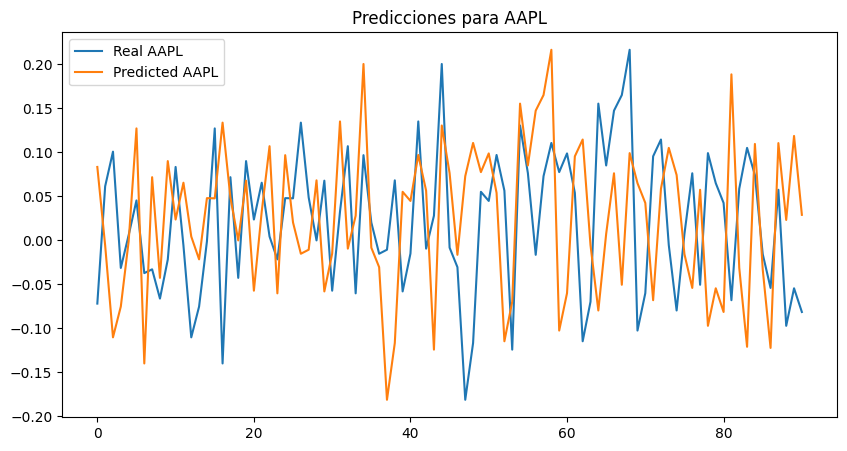

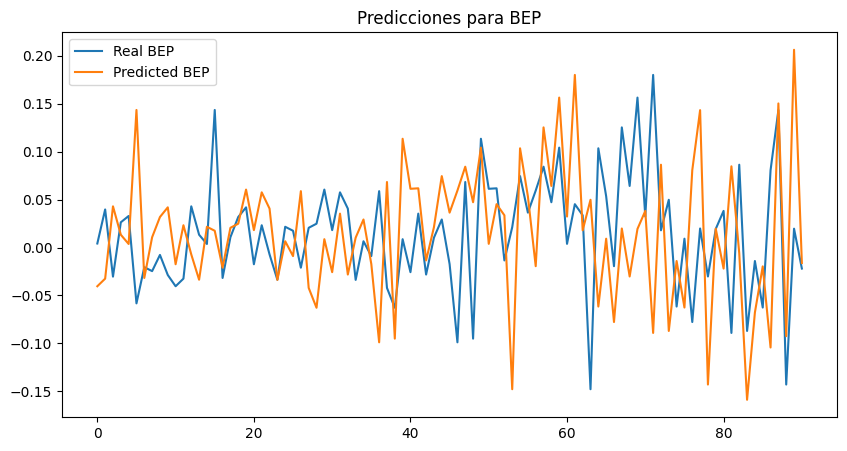

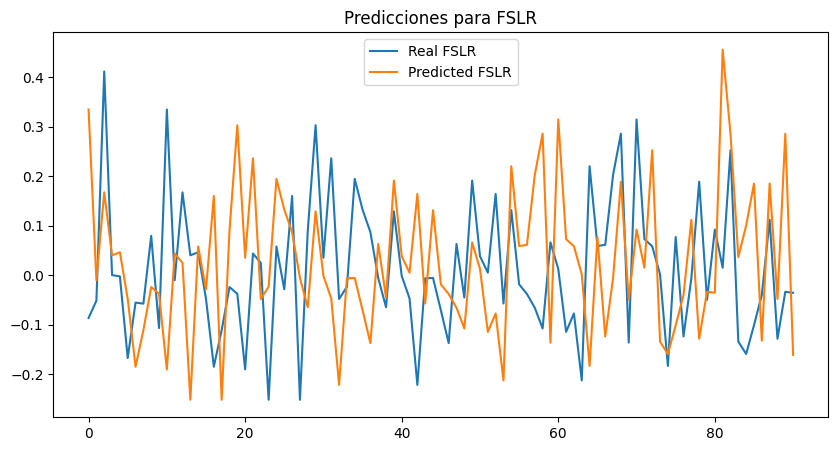

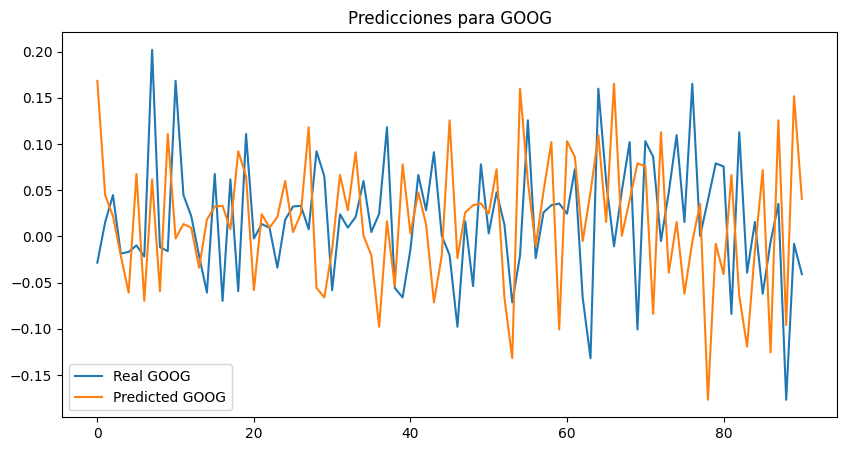

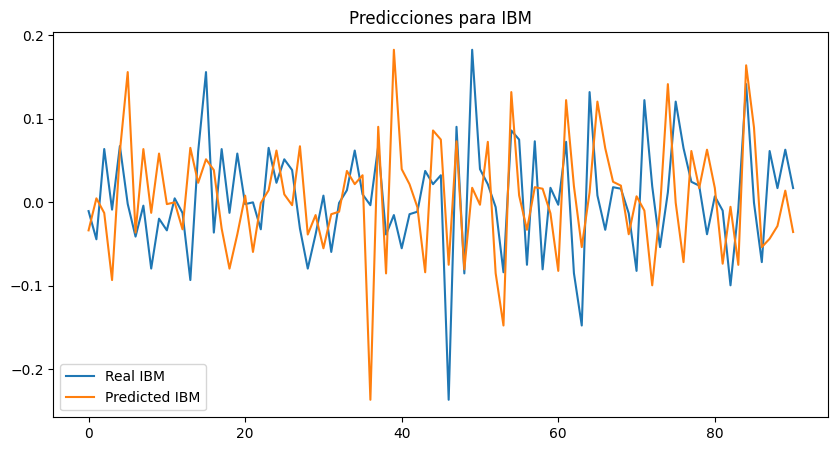

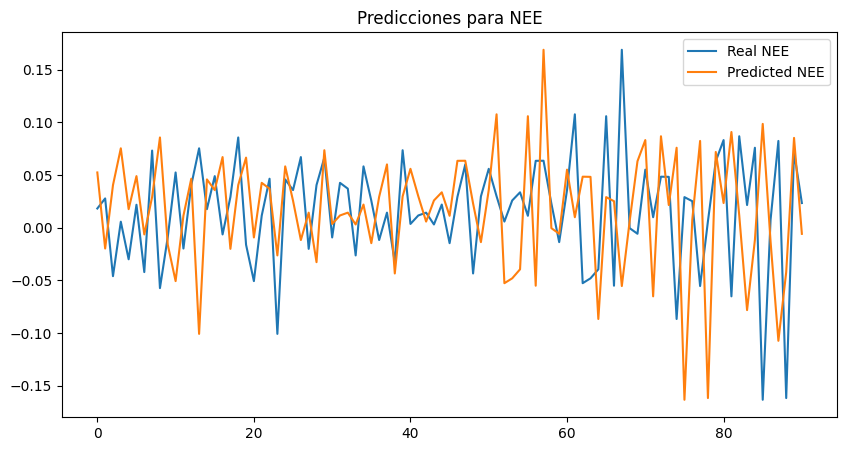

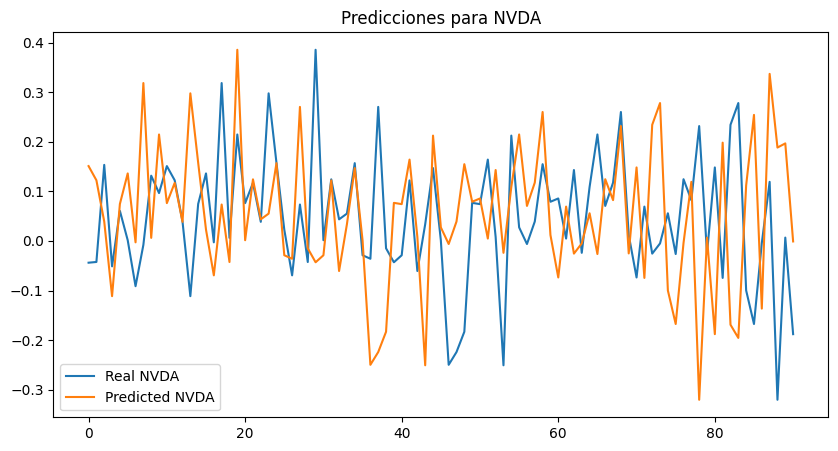

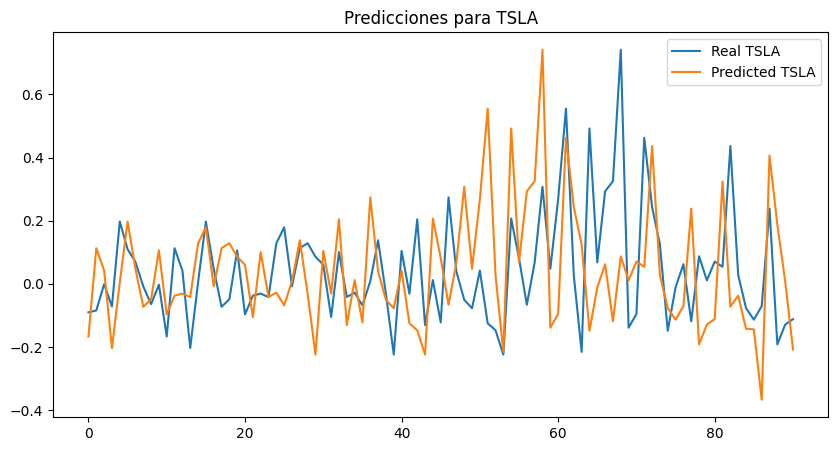

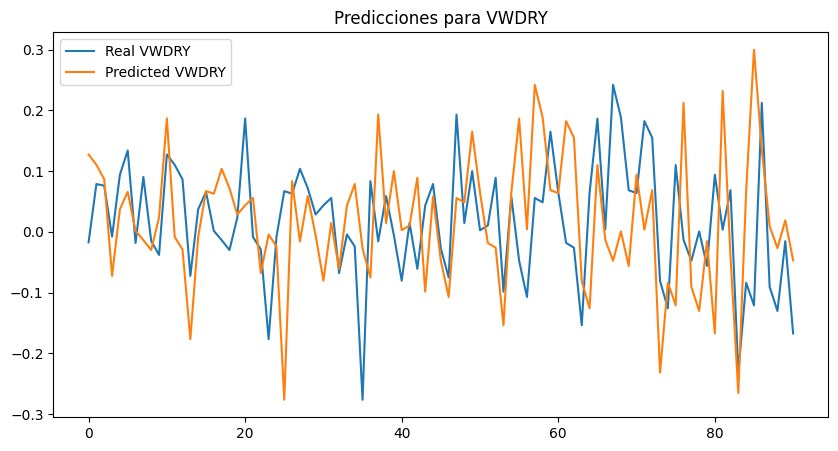

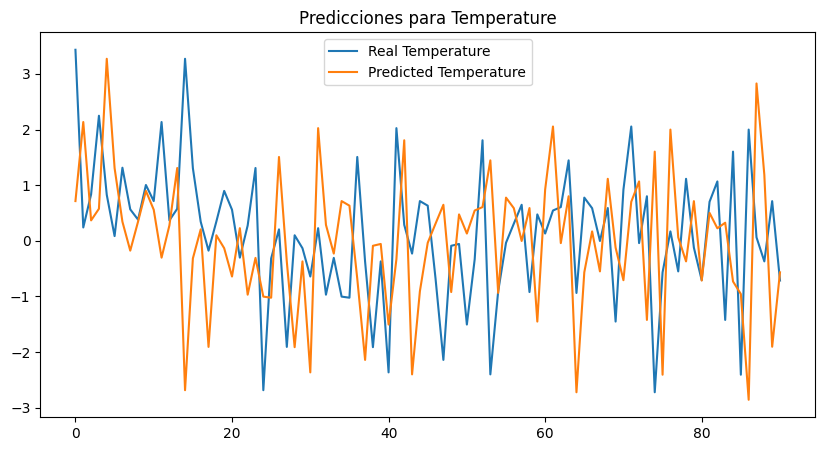

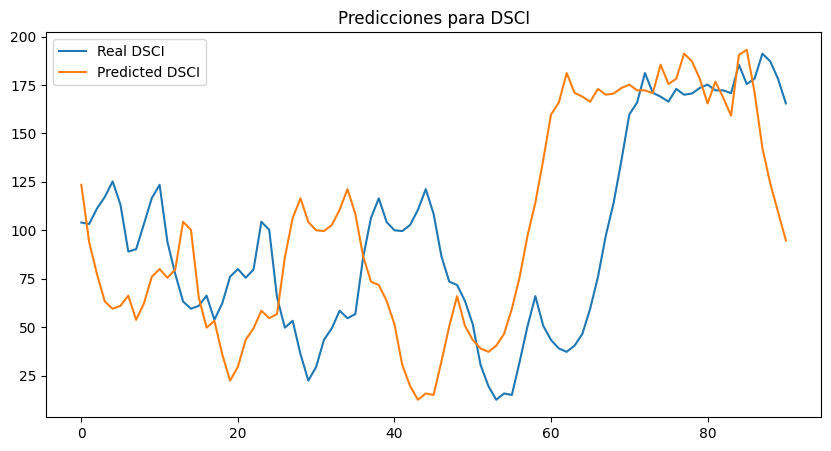

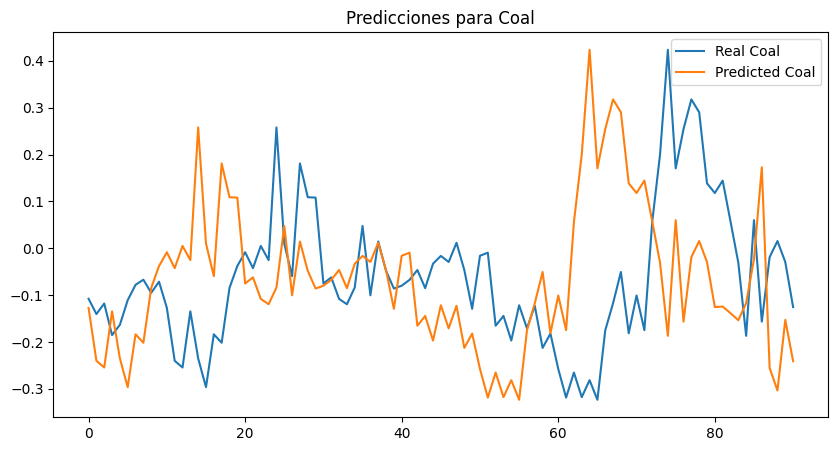

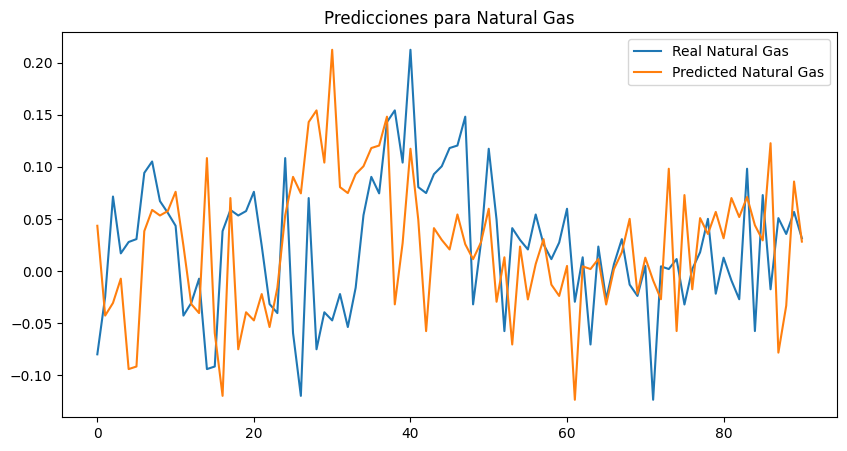

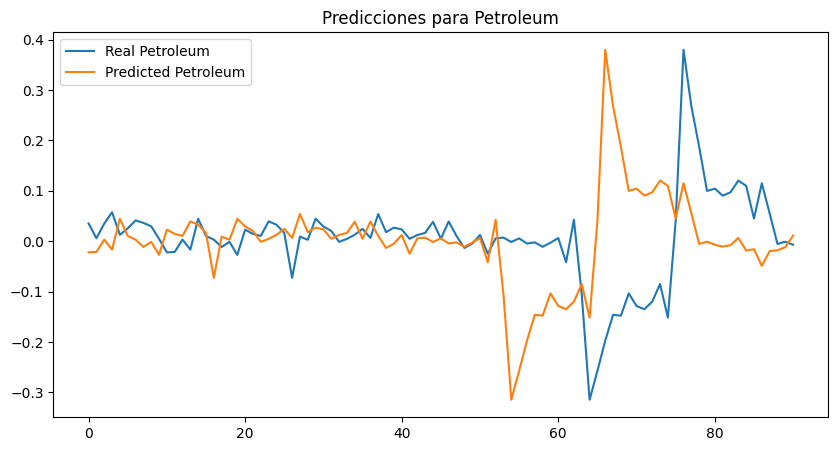

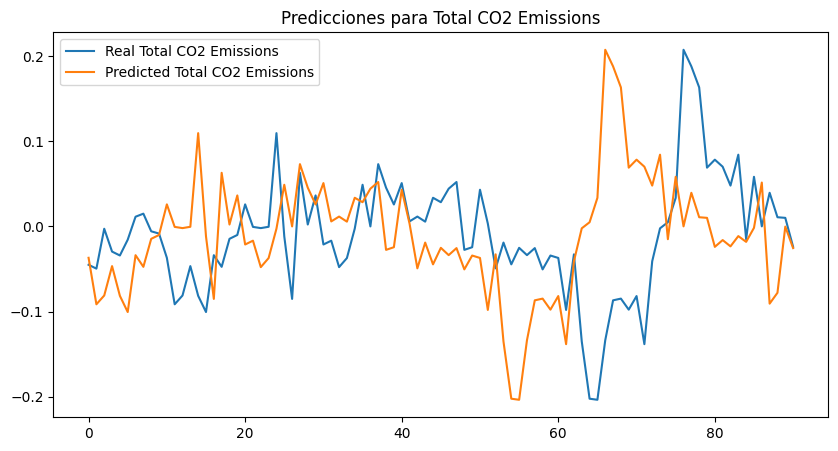

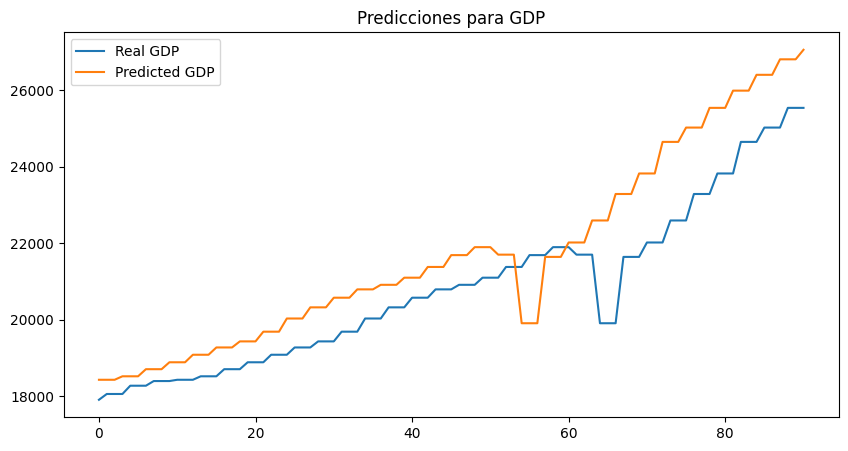

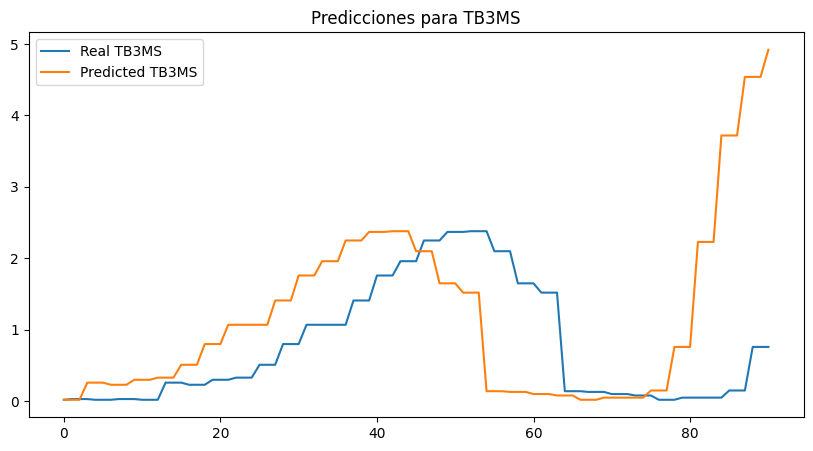

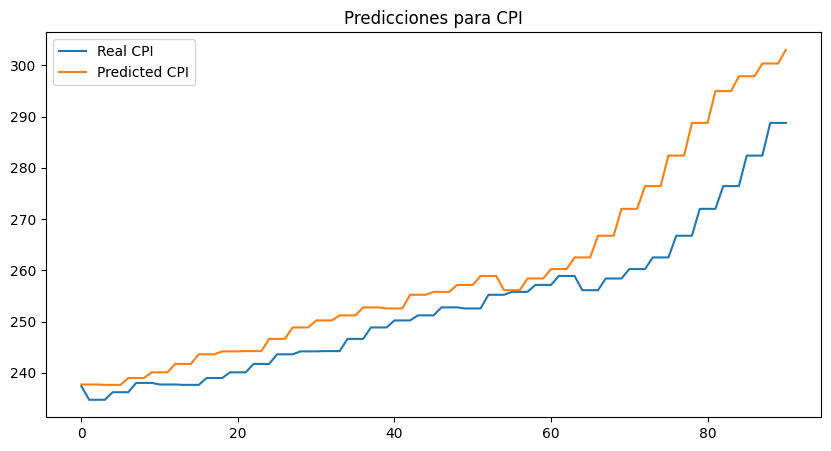

In [6]:
# Graficar las predicciones versus los datos originales
for i, column in enumerate(all_data.columns):
    plt.figure(figsize=(10, 5))
    plt.plot(all_data.index[:len(predict)], all_data.iloc[:len(predict), i], label=f"Real {column}")
    plt.plot(all_data.index[:len(predict)], predict[:, i], label=f"Predicted {column}")
    plt.title(f"Predicciones para {column}")
    plt.legend()
    plt.show()

Escenario Optimista:


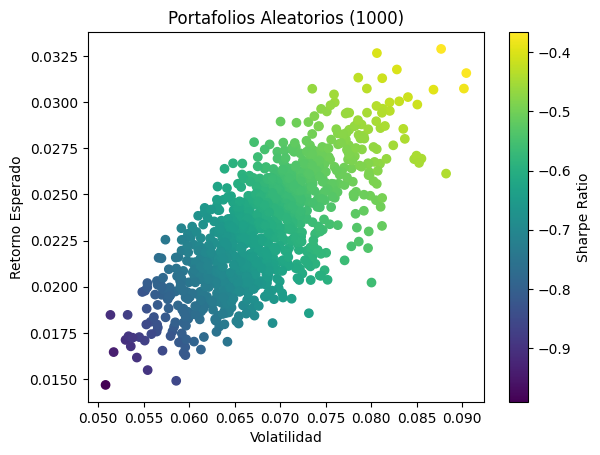

Escenario Pesimista:


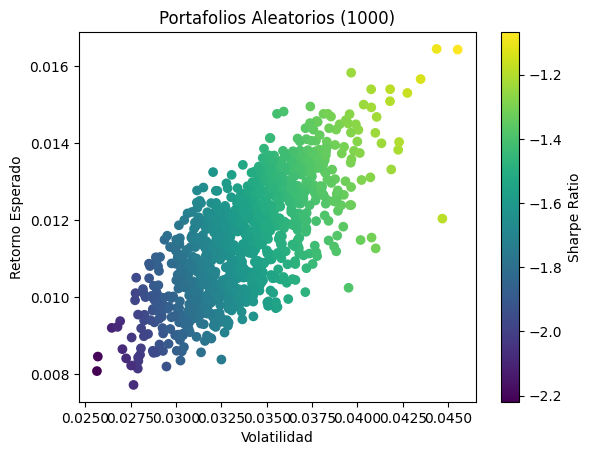

In [11]:
# Crear dos escenarios: optimista y pesimista
def create_optimistic_and_pessimistic_scenarios(asset_returns):
    """
    Crea dos escenarios ajustando los retornos históricos:
    - Optimista: Usa los retornos históricos normales.
    - Pesimista: Reduce los retornos en un factor pesimista.
    
    :param asset_returns: Retornos históricos de los activos.
    :return: Retornos ajustados para escenarios optimistas y pesimistas.
    """
    # Filtrar solo columnas numéricas
    numeric_returns = asset_returns.select_dtypes(include=[np.number])
    
    # Escenario optimista: usar los retornos históricos
    optimistic_returns = numeric_returns.copy()
    
    # Escenario pesimista: reducir los retornos, solo se aplican a los valores numéricos
    pessimistic_returns = numeric_returns.copy()
    pessimistic_returns.loc[:, :] = pessimistic_returns * 0.5  # Operación solo sobre los valores
    
    return optimistic_returns, pessimistic_returns



# Escenarios
optimistic_returns, pessimistic_returns = create_optimistic_and_pessimistic_scenarios(asset_prices)


# Instancia para el escenario optimista
optimizer_optimistic = PortfolioOptimizer(optimistic_returns, rf)

# Instancia para el escenario pesimista
optimizer_pessimistic = PortfolioOptimizer(pessimistic_returns, rf)

# Generar y graficar muchos portafolios para ambos escenarios
print("Escenario Optimista:")
df_optimistic, _ = optimizer_optimistic.plot_random_portfolios(num_portfolios=1000)

print("Escenario Pesimista:")
df_pessimistic, _ = optimizer_pessimistic.plot_random_portfolios(num_portfolios=1000)
